Display this as a slide deck using [RISE](https://damianavila.github.io/RISE/).

# Quantum Edge Detection

This demonstration shows how to use [Qiskit™](https://qiskit.org/) to perform edge detection in images with the quantum Hadamard edge detection algorithm, which completes the task with just one single-qubit operation, independent of the size of the image, illustrating the potential of quantum image processing for highly efficient image and video processing.

![noimg](./edge.png)

Read the example image in and display it.

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

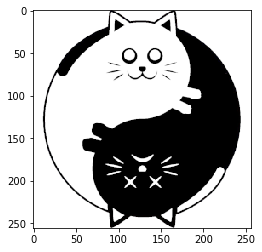

In [2]:
filename = './schrodin_yang.png'
im = mpimg.imread(filename)
fig, ax = plt.subplots()
ax.imshow(im)

If necessary, shrink the image to make the rest of the demonstration run faster.

In [3]:
from skimage.transform import resize

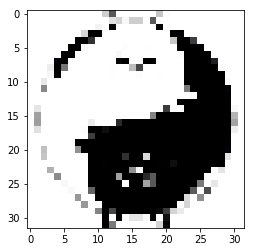

In [4]:
n_pixels = 2**5
im = resize(im, (n_pixels, n_pixels))
fig, ax = plt.subplots()
ax.imshow(im)

## Representing the Image as a State Vector

Get the first color channel of the image and `ravel` it to form a 1-D vector.

In [5]:
data = im[:,:,0].ravel()

Represent the image as a quantum state

$$ |A\rangle = \sum_k \alpha_k |k\rangle $$

where the computational basis $|k\rangle$ encodes the position of each pixel and the amplitude $\alpha_k$ encodes the pixel value.

In [6]:
from qiskit_aqua.components.initial_states import Custom

ModuleNotFoundError: No module named 'qiskit_aqua'

In [7]:
n_qubits   = np.int_(np.log2(len(data)))
init_state = Custom(n_qubits, state_vector=data)

Get the quantum circuit `circ` that creates the image representation and its registers `qr`. The circuit's registers begin in the zero state and end in the state that represents the image.

In [8]:
circ = init_state.construct_circuit('circuit')
qr   = circ.qregs

Create a copy of this circuit to try out different algorithms without having to regenerate it.

In [9]:
from copy import deepcopy

In [10]:
circ_init = deepcopy(circ)

## How the Quantum Hadamard Edge Detection Algorithm Works

The positions of any pair of neighboring pixels in `im` are the binary sequences $\{b_{n-1},\ldots, b_1, 0\}$ and $\{b_{n-1},\ldots, b_1, 1\}$, with $b_j$ taking on the value $0$ or $1$. The values of the neighboring pixels are stored as the amplitudes $\alpha_{\{b_{n-1},\ldots, b_1, 0\}}$ and $\alpha_{\{b_{n-1},\ldots,b_1,1\}}$ of the associated computational basis states.

The Hadamard gate $H$ maps $|0\rangle \rightarrow (|0\rangle + |1\rangle)/\sqrt{2}$, and $|1\rangle \rightarrow (|0\rangle - |1\rangle)/\sqrt{2}$. 

Performing a Hadamard gate on the least significant qubit changes the amplitudes to $\alpha_{\{b_{n-1},\ldots,b_1,0\}} \pm \alpha_{\{b_{n-1},\ldots,b_1,1\}}$. The even elements of the resulting state ($\alpha_{\{b_{n-1},\ldots,b_1,0\}} - \alpha_{\{b_{n-1},\ldots,b_1,1\}}$) form the nearest neighboring pixel value differences that indicate edges when its values are non-zero.

The edge information in the even positions can be extracted by measuring the least significant qubit. If its value is $1$, then the state of the other $n-1$ qubits indicate the edges between pixels at positions 0/1, 2/3, etc.

Applying the Hadamard gate on the least significant qubit can be represented as the tensor matrix product

$$ I_{2^{n-1}} \otimes H : 
\begin{pmatrix} 
\alpha_0 \\ \alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \vdots \\ \alpha_{N-2} \\ \alpha_{N-1} 
\end{pmatrix} 
\mapsto
\frac{1}{\sqrt{2}}
\begin{pmatrix} 
\alpha_0+\alpha_1 \\ \alpha_0-\alpha_1 \\ \alpha_2+\alpha_3 \\ \alpha_2-\alpha_3 \\ \vdots \\ \alpha_{N-2}+\alpha_{N-1} \\ \alpha_{N-2}-\alpha_{N-1} 
\end{pmatrix} 
$$

## Implementing the Algorithm

Beginning with the circuit `circ` that generates the image's state vector representation, apply the Hadamard gate to the least significant qubit.

In [11]:
circ.h(qr[0][0])

Simulate the circuit using the `StatevectorSimulator` and read the resulting state vector.

In [12]:
from qiskit import BasicAer, execute

In [13]:
simulator = BasicAer.get_backend('statevector_simulator')
result = execute(circ, simulator).result()
final_state_vector = result.get_statevector(circ)

/miniconda3/envs/QiskitPublic/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


## Decode the State Vector Back into an Image

In [14]:
edge_even = np.real(final_state_vector)
n_rows    = int(np.sqrt(len(edge_even)))
edge_even = edge_even.reshape(n_rows, -1)

The edges are indicated by the basis states where the least significant qubit is $1$. After decoding the 1-D state vector back into a 2-D image, these basis states are the 2-D image's even columns. To retain only these columns, zero out the odd columns.

In [15]:
edge_even[:,::2] = 0

Display the edges and the original image for comparison.

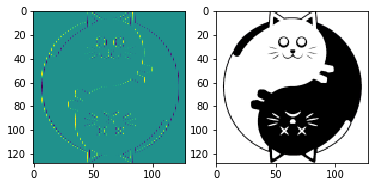

In [16]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(edge_even)
ax[1].imshow(im)

## Finding the Edges of the Odd Columns

So far, the boundaries have been found between the pixels at position 0/1, 2/3, etc. To get the boundaries between the remaining pairs 1/2, 3/4, etc., cyclically shift the quantum registers by one position and apply the same algorithm as above. The shifting operator $\Pi_{2^{n}}$ would have the following affect on the left; and after shifting, applying the Hadamard gate to the least significant qubit has the overall effect on the right:

$$ \Pi_{2^{n}} : 
\begin{pmatrix} 
\alpha_0 \\ \alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \vdots \\ \alpha_{N-2} \\ \alpha_{N-1} 
\end{pmatrix} 
\mapsto
\begin{pmatrix} 
\alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \alpha_4 \\ \vdots \\ \alpha_{N-1} \\ \alpha_{0} 
\end{pmatrix}
,\qquad
(I_{2^{n-1}} \otimes H) \Pi_{2^{n}} : 
\begin{pmatrix} 
\alpha_0 \\ \alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \vdots \\ \alpha_{N-2} \\ \alpha_{N-1} 
\end{pmatrix} 
\mapsto
\frac{1}{\sqrt{2}}
\begin{pmatrix} 
\alpha_1+\alpha_2 \\ \alpha_1-\alpha_2 \\ \alpha_3+\alpha_4 \\ \alpha_3-\alpha_4 \\ \vdots \\ \alpha_{N-1}+\alpha_{0} \\ \alpha_{N-1}-\alpha_{0} 
\end{pmatrix}
$$


Recall that $N$ is the number of bits and $n$ is the number of qubits, so $N = 2^n$. 



## Building the Shift Operation

The shift operation can be built up out of the quantum Fourier transform, its inverse, and single-qubit phase shift gates.

The quantum Fourier transform $F$ takes a state in the $|x\rangle$ space to a state in the $|k\rangle$ space according to

$$F |x\rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} \exp \left[ i\frac{2\pi}{N} x k  \right] |k\rangle$$

The value of $x$ can be shifted by an amount $p$ by multiplying by an exponential factor according to

$$P F |x\rangle \mapsto \exp\left[ i \frac{2\pi}{N} x p \right] \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} \exp \left[ i\frac{2\pi}{N} x k  \right] |k\rangle = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} \exp \left[ i\frac{2\pi}{N} (x+p) k  \right] |k\rangle$$

Finally, applying the inverse Fourier transform $F^\dagger$ maps from the $|k\rangle$ space back to the $|x\rangle$ space according to

$$F^\dagger P F |x\rangle \mapsto |x+p\rangle$$

Implement the three operations described above to define the function `shiftBases(c,q,n,p)` that shifts the registers `q` of a circuit `c` with `n` qubits by `p` positions.

In [17]:
def qft(c, q, n):
    """n-qubit QFT on q in c."""
    for j in range(n):
        for k in range(j):
            c.cu1(pi/float(2**(j-k)), q[j], q[k])
        c.h(q[j])
        
def iqft(c, q, n):
    """n-qubit IQFT on q in c."""
    for j in range(n):
        for k in range(j):
            c.cu1(-pi/float(2**(j-k)), q[int(n-j-1)], q[int(n-k-1)])
        c.h(q[int(n-j-1)])
        
def shiftBases(c, q, n, p):
    """Shift the register q by p positions"""
    iqft(c,q,n)
    for k in range(n):
        c.u1(-p*2*pi/float(2**(n-k)), q[int(n-k-1)])
    qft(c,q,n)

Build a test circuit to see how it relates to the algebraic operation above.

In [18]:
from qiskit import QuantumRegister, QuantumCircuit

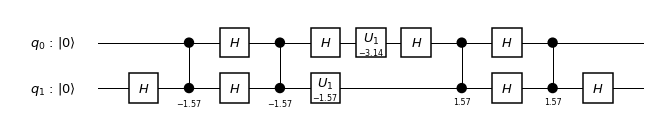

In [19]:
n = 2
q = QuantumRegister(n,'q')
c = QuantumCircuit(q)
iqft(c,q,n)
shiftBases(c,q,n,1)
qft(c,q,n)
c.draw(output='mpl')

## Using the Shift Operation to Find the Odd Edges

Use a copy of the image initialization circuit to avoid recalculating the image to state vector encoding.

In [20]:
circ = deepcopy(circ_init)
qr   = circ.qregs

Apply the shift, then the Hadamard gate as in the case of the even edges, then shift back.

In [21]:
shiftBases(circ,qr[0],n_qubits,1)
circ.h(qr[0][0])
shiftBases(circ,qr[0],n_qubits,-1)

Proceed as in the case of the even edges.

In [22]:
simulator = BasicAer.get_backend('statevector_simulator')
result = execute(circ, simulator).result()
final_state_vector = result.get_statevector(circ)

In [23]:
edge_odd = np.real(final_state_vector)
n_rows = np.int_(np.sqrt(len(edge_odd)))
edge_odd = edge_odd.reshape(n_rows, -1)

In [24]:
edge_odd[:,1::2] = 0

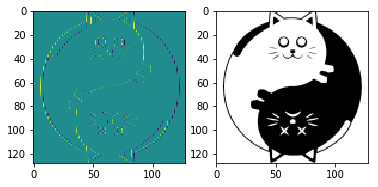

In [25]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(edge_odd)
ax[1].imshow(im)

## Bringing the Even and Odd Edges Together

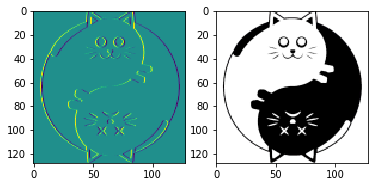

In [26]:
edge = edge_even + edge_odd

fig, ax = plt.subplots(1,2)
ax[0].imshow(edge)
ax[1].imshow(im)

We've built a quantum circuit that performs edge detection out of simple elements, motivating the use of quantum computation in image and video processing.

For an in depth exploration of this topic, refer to [Yao, Xi-Wei et al., Quantum Image Processing and Its Application to Edge Detection: Theory and Experiment, Phys. Rev. X 7, 031041, (2017)](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.7.031041).